In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Our model is an ensemble model from a bagging regressor and Gradient Boosting Regression from all features and Random Forest from features apart from Episode and Name of Episode and finally reporting the average

In [147]:
disc_features = ['Episode' , 'Station' , 'Channel Type' , 'Season' , 'Day of week'   , 'Genre' ,'Name of episode'
                ,'First time or rerun' , '# of episode in the season' , 'Movie?' , 'Game of the Canadiens during episode?'
                ,'day' , 'month' , 'year']
cont_features = ['Date' , 'Start_time' , 'End_time' , 'Length' , 'Temperature in Montreal during episode']#Length ?!

label = 'Market Share_total'


In [127]:
df =pd.read_csv('data.csv')
df.head()

,Unnamed: 0,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Name of episode,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Market Share_total,Temperature in Montreal during episode
0,1,Vidéoclips V,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 06:00:00,2016-08-29 08:00:00,8,Vidéoclips V,NaN,Music Video Clips,No,Yes,No,No,0.9,20.400
1,2,Apollo dans l'frigo,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 08:00:00,2016-08-29 08:30:00,2,Apollo dans l'frigo,NaN,Informal Education and Recreation and Leisure,No,Yes,No,No,0.5,19.125
2,3,Infopublicité,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 08:30:00,2016-08-29 09:00:00,2,Infopublicité,NaN,"Infomercials, Promotional and Corporate Videos",No,Yes,No,No,0.3,19.125
3,4,"Infos, Les",V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 09:00:00,2016-08-29 10:00:00,4,"Infos, Les",NaN,News,No,Yes,No,No,1.7,18.125
4,5,"Souper presque parfait, Un",V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 10:00:00,2016-08-29 10:30:00,2,"Souper presque parfait, Un",NaN,Reality Programs,No,Yes,No,No,2.2,18.250


0                               Vidéoclips V
1                        Apollo dans l'frigo
2                              Infopublicité
3                                 Infos, Les
4                 Souper presque parfait, Un
5                        Opération séduction
6                               Tic tac show
7                                 Révolution
8                                 CSI: Miami
9                                 CSI: Miami
10                Tempêtes solaires (1 de 2)
11                              Simpson, Les
12                              Simpson, Les
13                      Guerre des clans, La
14                            Atomes crochus
15                Souper presque parfait, Un
16                          Détestables, Les
17                                    Et si?
18                                CSI: Miami
19                            Mentaliste, Le
20                               Arbitre, L'
21                            Atomes crochus
22        

In [142]:
import datetime
def preprocess(df):
    disc_features = ['Episode' , 'Station' , 'Channel Type' , 'Season' , 'Day of week'   , 'Genre' ,'Name of episode'
                ,'First time or rerun' , '# of episode in the season' , 'Movie?' , 'Game of the Canadiens during episode?']
    df=df.drop(df.columns[0] , axis=1) #droping index column
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.drop(['Year' , 'Name of show'] , axis=1)
    df['Start_time'] = pd.to_datetime(df['Start_time'])
    df['End_time'] = pd.to_datetime(df['End_time'])
    temp = (df['Start_time'].apply(lambda x : x.date()) == df['Date'].apply(lambda x : x.date()))
    nantimes = temp[temp==False]
    doublemissed = [(t,t+1) for t in nantimes.index if t+1 in nantimes.index]
    #filling nan values
    for i,t in nantimes.iteritems():
        if i-1 not in nantimes.index:
            df.iloc[i,df.columns.get_loc('Start_time')]=df.iloc[i-1]['End_time']
        if i+1 not in nantimes.index:
            df.iloc[i,df.columns.get_loc('End_time')]=df.iloc[i+1]['End_time']
    for t in doublemissed:
        df.iloc[t[0] , df.columns.get_loc('End_time')] = df.iloc[t[0]]['Start_time'] + datetime.timedelta(minutes = int(df.iloc[t[0]]['Length']*15))
        df.iloc[t[1] , df.columns.get_loc('Start_time')] = df.iloc[t[0]]['End_time']

    c = 'Temperature in Montreal during episode'
    ttc = df.groupby('Date').mean()
    notfilled=[]
    temp = df['Temperature in Montreal during episode'].isna()
    nantemp = temp[temp==True]
    for i,t in nantemp.iteritems():
        df.iloc[i,df.columns.get_loc(c)]=ttc.loc[df.iloc[i]['Date']][c] #average of temp in that day
    
    df['Name of episode'] = df['Name of episode'].fillna(df['Episode'])
    df['day'] = df['Date'].apply(lambda x : x.day)
    df['month'] = df['Date'].apply(lambda x : x.month)
    df['year'] = df['Date'].apply(lambda x : x.year)
    df = df.drop('Date' , axis=1)
    df['Start_time'] = df['Start_time'].apply(lambda x : x.time()).apply(lambda x : x.hour*60 + x.minute).astype('float32')
    df['End_time'] = df['End_time'].apply(lambda x : x.time()).apply(lambda x : x.hour*60 + x.minute).astype('float32')
    for c in disc_features:
        df[c] = df[c].astype('category').cat.codes
    return df

In [143]:
df = preprocess(df)
df.head()

,Episode,Station,Channel Type,Season,Day of week,Start_time,End_time,Length,Name of episode,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Market Share_total,Temperature in Montreal during episode,day,month,year
0,6388,21,0,0,1,360.0,480.0,8,79725,11,0,1,0,0,0.9,20.400,29,8,2016
1,249,21,0,0,1,480.0,510.0,2,16376,8,0,1,0,0,0.5,19.125,29,8,2016
2,2086,21,0,0,1,510.0,540.0,2,34642,7,0,1,0,0,0.3,19.125,29,8,2016
3,2088,21,0,0,1,540.0,600.0,4,34646,14,0,1,0,0,1.7,18.125,29,8,2016
4,5870,21,0,0,1,600.0,630.0,2,72884,20,0,1,0,0,2.2,18.250,29,8,2016


In [162]:
dftrain = df.drop(label , axis=1)

In [161]:
dftest.shape

(154165, 18)

In [197]:
features = disc_features[:]

from sklearn.preprocessing import OneHotEncoder , LabelBinarizer
from sklearn.compose import ColumnTransformer 
transformer = ColumnTransformer(  
    transformers=[
        ("all",        # Just a name
         OneHotEncoder(), # The transformer class
         [list(dftrain.columns).index(e) for e in disc_features ]       # The column(s) to be applied on.
         ),
    ], remainder='passthrough'
)

transformer.fit(dftrain.append(dftest))

c:\users\sajjad\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('all', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True), [0, 1, 2, 3, 4, 9, 8, 10, 11, 12, 13, 15, 16, 17])])

In [20]:
def sampleEp(df ,frac=0.66, episodefrac = 0.7 ,label = 'Market Share_total'):
    """sample training set in a way that 1-episodefrac of episode in test differ frm train """
    n = len(df)
    train=df.sort_values('Episode')
    test = train.loc[int(len(df)*frac):].sample(frac=1)
    train = train.loc[:int(len(df)*frac)].sample(frac=1)
    test = test.sample(n = int(n*(1-frac)*(1-episodefrac)) , replace = True).append(train.sample(n=int(n*(1-frac)*episodefrac),replace=True))
    train = train.sample(n=int(n*episodefrac),replace=True)
    X_train = train.drop(label , axis=1)
    Y_train = train[label]
    X_test = test.drop(label , axis=1)
    Y_test = test[label]
    return X_train , X_test , Y_train , Y_test

In [164]:
X_train , X_test , Y_train , Y_test = sampleEp(df)

In [220]:
data = transformer.transform(X_train)
data.shape

(431659, 97411)

In [221]:
datat = transformer.transform(X_test)

In [168]:
from sklearn.ensemble import BaggingRegressor 

reg = BaggingRegressor().fit(data,Y_train) #firest model to memorize everything 

In [169]:
print("Score on train is {} \nScore on test is {}".format(reg.score(data , Y_train) , reg.score(datat , Y_test)))

Score on train is 0.989036660811506 
Score on test is 0.7350067269811852


In [222]:
from sklearn.ensemble import GradientBoostingRegressor 

reg4 = GradientBoostingRegressor().fit(data,Y_train) #firest model to memorize everything 

In [223]:
print("Score on train is {} \nScore on test is {}".format(reg4.score(data , Y_train) , reg4.score(datat , Y_test)))

Score on train is 0.7791447247304103 
Score on test is 0.7577707808941909


In [170]:
from sklearn.linear_model import LinearRegression 

reg2 = LinearRegression().fit(data , Y_train)

In [172]:
datat = transformer.transform(X_test)
print("Score on train is {} \nScore on test is {}".format(reg2.score(data , Y_train) , reg2.score(datat , Y_test)))

Score on train is 0.8835098241351559 
Score on test is 0.7323251501558842


In [176]:
dftrain.head()

,Episode,Station,Channel Type,Season,Day of week,Start_time,End_time,Length,Name of episode,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Temperature in Montreal during episode,day,month,year
0,6388,21,0,0,1,360.0,480.0,8,79725,11,0,1,0,0,20.400,29,8,2016
1,249,21,0,0,1,480.0,510.0,2,16376,8,0,1,0,0,19.125,29,8,2016
2,2086,21,0,0,1,510.0,540.0,2,34642,7,0,1,0,0,19.125,29,8,2016
3,2088,21,0,0,1,540.0,600.0,4,34646,14,0,1,0,0,18.125,29,8,2016
4,5870,21,0,0,1,600.0,630.0,2,72884,20,0,1,0,0,18.250,29,8,2016


In [202]:
features = [e for e in dftrain.columns if e not in ['Episode' , 'Name of episode']]
transformer2 = ColumnTransformer(  
    transformers=[
        ("all",        # Just a name
         OneHotEncoder(), # The transformer class
         [list(dftrain[features].columns).index(e) for e in [m for m in disc_features if m not in ['Episode' , 'Name of episode'] ] ]      # The column(s) to be applied on.
         ),
    ], remainder='passthrough'
)

transformer2.fit(dftrain[features].append(dftest[features]))

c:\users\sajjad\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('all', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True), [0, 1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15])])

In [181]:
data = transformer2.transform(X_train[features])
data.shape

(431659, 123)

In [188]:
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
reg3 = RandomForestRegressor().fit(data , Y_train)

c:\users\sajjad\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [189]:
datat = transformer2.transform(X_test[features])
print("Score on train is {} \nScore on test is {}".format(reg3.score(data , Y_train) , reg3.score(datat , Y_test)))

Score on train is 0.9888711259389816 
Score on test is 0.8851304431876806


In [22]:
len(set(X_test['Episode']).difference(set(X_train['Episode'])))/len(X_test['Episode'].unique())

0.14739084132055377

In [17]:
X_train.head().append(X_test.head

(10, 17)

In [55]:
from keras.models import Sequential , Model
from keras.layers import Input , Dense , concatenate
from sklearn.metrics import roc_auc_score


In [57]:
features

['Episode',
 'Station',
 'Channel Type',
 'Season',
 'Day of week',
 'Genre',
 'Name of episode',
 'First time or rerun',
 '# of episode in the season',
 'Movie?',
 'Game of the Canadiens during episode?']

### lets submit

In [151]:
dftest = pd.read_csv('test.csv')
dftest.head()

,Unnamed: 0,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Name of episode,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Temperature in Montreal during episode
0,1,Mom V.F. (M),VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 11:30:00,2019-01-22 12:00:00,2,Mom V.F. (M),Abstinence,Ongoing Comedy Series (Sitcoms),No,Yes,No,No,-22.525
1,2,2 filles fauchées,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 12:00:00,2019-01-22 12:30:00,2,2 filles fauchées,Et la rupture,Ongoing Comedy Series (Sitcoms),No,Yes,No,No,-21.625
2,3,The Big Bang Theory,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 12:30:00,2019-01-22 13:00:00,2,The Big Bang Theory,La désintégration de la sonde spatiale,Ongoing Comedy Series (Sitcoms),No,Yes,No,No,-21.625
3,4,Flashpoint,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 13:00:00,2019-01-22 14:00:00,4,Flashpoint,Retraite impossible (P),Ongoing Dramatic Series,Yes,Yes,No,No,-20.375
4,5,Les Frères Scott,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 14:00:00,2019-01-22 15:00:00,4,Les Frères Scott,Premières désillusions,Ongoing Dramatic Series,No,Yes,No,No,-19.100


In [152]:
dftest = preprocess(dftest)

In [154]:
dftest.head()

,Episode,Station,Channel Type,Season,Day of week,Start_time,End_time,Length,Name of episode,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Temperature in Montreal during episode,day,month,year
0,1487,20,1,2,5,690.0,720.0,2,7233,15,0,1,0,0,-22.525,22,1,2019
1,14,20,1,2,5,720.0,750.0,2,13372,15,0,1,0,0,-21.625,22,1,2019
2,2492,20,1,2,5,750.0,780.0,2,17969,15,0,1,0,0,-21.625,22,1,2019
3,709,20,1,2,5,780.0,840.0,4,28237,16,1,1,0,0,-20.375,22,1,2019
4,1257,20,1,2,5,840.0,900.0,4,27103,16,0,1,0,0,-19.100,22,1,2019


In [204]:
xtest = transformer.transform(dftest)
xtest2 = transformer2.transform(dftest[features])

In [233]:
dftest[label] = (0.33*reg4.predict(xtest) + 0.33*reg4.predict(xtest) +0.33*reg3.predict(xtest2))

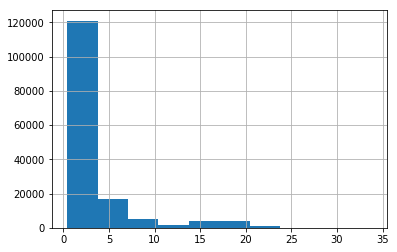

In [234]:
dftest[label].hist()

In [235]:
dffinal = pd.read_csv('test.csv')
dffinal=dffinal.drop(dffinal.columns[0] , axis=1)

In [237]:
dffinal[label] = dftest[label]

In [239]:
dffinal.head(100)

,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Name of episode,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Temperature in Montreal during episode,Market Share_total
0,Mom V.F. (M),VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 11:30:00,2019-01-22 12:00:00,2,Mom V.F. (M),Abstinence,Ongoing Comedy Series (Sitcoms),No,Yes,No,No,-22.525000,0.499951
1,2 filles fauchées,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 12:00:00,2019-01-22 12:30:00,2,2 filles fauchées,Et la rupture,Ongoing Comedy Series (Sitcoms),No,Yes,No,No,-21.625000,0.499951
2,The Big Bang Theory,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 12:30:00,2019-01-22 13:00:00,2,The Big Bang Theory,La désintégration de la sonde spatiale,Ongoing Comedy Series (Sitcoms),No,Yes,No,No,-21.625000,0.526351
3,Flashpoint,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 13:00:00,2019-01-22 14:00:00,4,Flashpoint,Retraite impossible (P),Ongoing Dramatic Series,Yes,Yes,No,No,-20.375000,0.483451
4,Les Frères Scott,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 14:00:00,2019-01-22 15:00:00,4,Les Frères Scott,Premières désillusions,Ongoing Dramatic Series,No,Yes,No,No,-19.100000,0.460351
5,The Bold Type : de celles qui osent,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 15:00:00,2019-01-22 16:00:00,4,The Bold Type : de celles qui osent,Jusqu'au petit matin,Ongoing Dramatic Series,No,Yes,No,No,-17.825000,0.463651
6,Sirène,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 16:00:00,2019-01-22 17:00:00,4,Sirène,Expérimentations,Ongoing Dramatic Series,No,Yes,No,No,-16.750000,0.559351
7,Jouer le jeu,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 17:00:00,2019-01-22 17:30:00,2,Jouer le jeu,Bal obligatoire,Ongoing Comedy Series (Sitcoms),No,Yes,No,No,-16.300000,0.516451
8,Le chalet,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 17:30:00,2019-01-22 18:00:00,2,Le chalet,La fois où Antoine était juste un gérant de bo...,Ongoing Dramatic Series,No,Yes,No,No,-16.300000,0.787051
9,Max et Livia,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,2019-01-22 18:00:00,2019-01-22 18:30:00,2,Max et Livia,Triangle Amoureux,Ongoing Dramatic Series,No,Yes,No,No,-15.925000,0.493351


In [241]:
dfreal = pd.read_csv('data.csv')
dfreal = dfreal.drop(dfreal.columns[0] , axis=1)
dfreal.head()

,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Name of episode,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Market Share_total,Temperature in Montreal during episode
0,Vidéoclips V,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 06:00:00,2016-08-29 08:00:00,8,Vidéoclips V,NaN,Music Video Clips,No,Yes,No,No,0.9,20.400
1,Apollo dans l'frigo,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 08:00:00,2016-08-29 08:30:00,2,Apollo dans l'frigo,NaN,Informal Education and Recreation and Leisure,No,Yes,No,No,0.5,19.125
2,Infopublicité,V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 08:30:00,2016-08-29 09:00:00,2,Infopublicité,NaN,"Infomercials, Promotional and Corporate Videos",No,Yes,No,No,0.3,19.125
3,"Infos, Les",V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 09:00:00,2016-08-29 10:00:00,4,"Infos, Les",NaN,News,No,Yes,No,No,1.7,18.125
4,"Souper presque parfait, Un",V Total,General Channel,Fall,2016,2016-08-29,Monday,2016-08-29 10:00:00,2016-08-29 10:30:00,2,"Souper presque parfait, Un",NaN,Reality Programs,No,Yes,No,No,2.2,18.250


In [262]:
dfreal[dfreal['Episode'] == dfreal['Episode'][100]][label].mean()

2.741500765696784

In [261]:
dffinal[dffinal['Episode'] == dfreal['Episode'][100]][label].mean()

2.149000642981192

In [263]:
dffinal.to_csv('final.csv' , index=False )

## Future improvement :
using a time series analysis would be a good idea for example give previous days marketshare as features to the model

Implement RNN 